# Loading the data 

Recipe Dataset Preprocessing Pipeline

This notebook preprocesses Recipe1M+ dataset to prepare it for analysis and modeling. 
The main preprocessing steps include:
1. Extracting cooking steps from recipe directions
2. Computing recipe complexity metrics
3. Calculating estimated cooking times
4. Cleaning and validating the data

In [30]:
# Import necessary libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Configure pandas display settings for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Load the recipe dataset
df = pd.read_csv('dataset/full_dataset.csv')


## Recipe Complexity Analysis
Here we analyze the complexity of recipes by counting the number of preparation steps.
This helps understand recipe difficulty and preparation time requirements.

We extract steps by:
1. Converting string representation of directions into Python lists
2. Counting the number of steps in each recipe
3. Analyzing the distribution of recipe complexity

In [3]:
def count_recipe_steps(directions_string):
    try:
        # Convert the string representation of a list into an actual Python list
        directions_list = ast.literal_eval(directions_string)
        # Return the length of the list (number of steps)
        return len(directions_list)
    except (ValueError, SyntaxError) as e:
        # If there's any error in conversion, return 0
        print(f"Error processing directions: {e}")
        return 0

# Add the new column to your DataFrame
df['number_of_steps'] = df['directions'].apply(count_recipe_steps)

So it can be inferred from below the max xooking steps is 165 and min is 1. 

In [4]:
print("\nSummary statistics for number of steps:")
print(df['number_of_steps'].max())
print(df['number_of_steps'].min())


Summary statistics for number of steps:
164
1


Cooking steps 165 seems little be absured but lets see what is the recipe for that have a cooking step of 165.

In [5]:
for direction in df[df['number_of_steps'] == 164]['directions']:
    print(direction)

["In a small saucepan, combine the sugar, citric acid, and water and let stand for 30 minutes.", "Then bring the mixture to a boil over medium heat and cook for 2 to 3 minutes, or until the syrup turns pale yellow (the color of canola oil).", "If the citric acid turns dark yellow during boiling, swirl the pan or stir the contents to distribute.", "Remove from the heat and pour into a large measuring cup or heatproof bowl.", "Set the syrup aside for about 4 hours to cool completely.", "It will thicken and darken a bit as it cools.", "Then cover with plastic wrap and keep at room temperature.", "There should be a scant 1 cup syrup.", "(The syrup can be made up to 3 days in advance and kept at room temperature until using.)", "Position a rack in the middle of the oven and preheat to 250F.", "Line a baking sheet with parchment paper.", "Crack each salted egg and separate the yolk from the white, discarding the white and depositing the yolk on the prepared baking sheet.", "Discard yolks tha

## Cooking Time Estimation
This section extracts and standardizes cooking times from recipe directions.

The process:
1. Uses regex to find time mentions (e.g. "10 minutes", "2 hours")
2. Converts all times to minutes for consistency
3. Sums up multiple time mentions within each recipe
4. Handles edge cases and data quality issues

In [6]:
import re
def extract_cooking_times(directions_string):
    """
    Extract and sum up all time durations mentioned in recipe directions.
    Returns total estimated cooking time in minutes.
    """
    try:
        directions_list = ast.literal_eval(directions_string)
    except:
        return 0
    
    total_minutes = 0
    
    # Dictionary for converting time units to minutes
    time_conversions = {
        'hour': 60,
        'hours': 60,
        'hr': 60,
        'hrs': 60,
        'minute': 1,
        'minutes': 1,
        'min': 1,
        'mins': 1
    }
    
    # Improved pattern to capture both number and unit together
    time_pattern = r'(\d+)\s*(hour|hours|hr|hrs|minute|minutes|min|mins)'
    
    for step in directions_list:
        # Search for time mentions in each step
        matches = re.finditer(time_pattern, step.lower())
        
        for match in matches:
            try:
                amount = int(match.group(1))  # The number
                unit = match.group(2)         # The time unit
                total_minutes += amount * time_conversions.get(unit, 0)
            except (ValueError, IndexError) as e:
                continue  # Skip any problematic matches
    
    return total_minutes
df['estimated_cooking_time'] = df['directions'].apply(extract_cooking_times)

In [7]:
df['estimated_cooking_time'].max()

np.int64(210060)

So the max cooking time is 210060 which is an outlier and its not possible. Lets have a closer look at the direction of that recipe. 

In [8]:
for direction in df[df['estimated_cooking_time'] == 210060]['directions']:
    print(direction)

["in a dutch oven brown ground beef with onions and garlic;drain.", "add remaining items except cheese mix well cover and bake 3501 hour", "sprinkle with cheese just before serving.", "Freeze leftovers."]


The error in cooking time has been generated by the fact that in the direction, they have ommitted a space between 350 and 1, therofre our function thinks that its 3501 hours, lets fix that by hardcoing the correct direction. 

In [9]:
recipe_index = df[df['estimated_cooking_time'] == 210060].index[0]

# Update the cell explicitly
df.at[recipe_index, 'directions'] = [
    "in a dutch oven brown ground beef with onions and garlic;drain.",
    "add remaining items except cheese mix well cover and bake 350 1 hour",
    "sprinkle with cheese just before serving.",
    "Freeze leftovers."
]

Generating a bar plot to understand tge distribution of the estimated cooking time. 

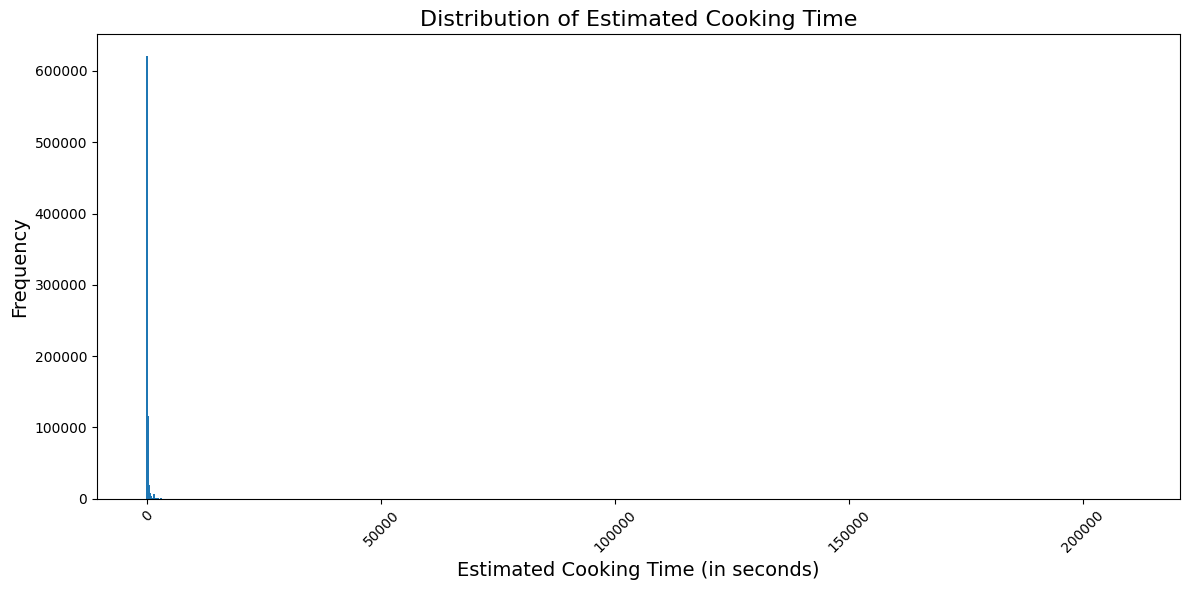

In [10]:
if 'estimated_cooking_time' in df.columns:
    # Create a barplot for the distribution of 'estimated_cooking_time'
    cooking_time_distribution = df['estimated_cooking_time'].value_counts().sort_index()

    plt.figure(figsize=(12, 6))
    plt.bar(cooking_time_distribution.index, cooking_time_distribution.values, width=500, align='center')
    plt.title('Distribution of Estimated Cooking Time', fontsize=16)
    plt.xlabel('Estimated Cooking Time (in seconds)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("The column 'estimated_cooking_time' does not exist in the DataFrame.")

Seems like there are not of other cases like the one that we dealth with. Its not humanly possible to hard code all the directions in proper format. We can use an LLM for makin the correction, in the future works. 

Lets see all the unique values in the estimated cooking time. 

In [14]:

unique_values = df['estimated_cooking_time'].value_counts().sort_index()

# Create a DataFrame to organize the output
unique_values_df = unique_values.reset_index()
unique_values_df.columns = ['Estimated Cooking Time', 'Frequency']
unique_values_df

,Estimated Cooking Time,Frequency
0,0,620385
1,1,14315
2,2,23811
3,3,23164
4,4,17064
...,...,...
3079,80799,1
3080,146160,1
3081,148380,1
3082,150410,1


In [18]:
df.shape

(2231142, 9)

In [29]:
a = sum(df['estimated_cooking_time'] > 300)
print(f'There are {a} recipes that have cooking time more than 300mins, which means {round((a/df.shape[0])*100,3)}% of the overall recipe.')

There are 95790 recipes that have cooking time more than 300mins, which means 4.293% of the overall recipe.


Its seems likie there are more error than we anitiicpated by looking at the frequcies. Lets get rid of all the rows that have cooking time more than 300 mins, since it makes less than 5% of the data. 

In [20]:
directions = df.loc[df['estimated_cooking_time'] > 300, 'directions']

# Display the 'directions' column for the selected rows
#print(directions)

Storing the cleaned df as a pickled obj to be used in the recommendation system. 

In [ ]:
import pickle
with open('cleaned_data.pkl', 'wb') as file:
    pickle.dump(df, file)